## **NOTES**

--------------------------------------------------------------------------

Class Weight	Özellikle Hip-Hop, Jazz, International, Spoken gibi daha az
sayıda örneğe sahip sınıflarda recall ve precision düşük. Class weight ile modelin nadir sınıfları daha önemsemesini sağlarsın.

Data Augmentation (Veri Artırımı)	Yine nadir sınıflar için veri artırımı (SpecAugment, pitch shift, time stretch) çok faydalı. Özellikle Spoken, Jazz, Hip-Hop gibi sınıflarda performansı artırır.

Veri Artırımı (ImageDataGenerator Geliştirme)	Şu an sade ImageDataGenerator kullanmışsın, ama mel-spectrogram üzerinde frekans ve zaman ekseni augmentasyonları (ör. frequency masking, time masking) özellikle ses türü için güçlü katkı sağlar.

Attention Layer (BiLSTM sonrası)	Şu an BiLSTM kullanıyorsun, ama hangi zaman aralıklarının önemli olduğunu fark etmesini sağlamak için Attention eklemek çok etkili olur. Zaman serileri için olmazsa olmaz hale geldi.

EarlyStopping ve ModelCheckpoint	Mevcut model çok güzel öğreniyor ancak overfitting riski her zaman var. Validation loss takip ederek gereksiz uzayan epochları engeller. Ayrıca en iyi modeli kaydedersin.


--------------------------------------------------------------------------

Learning Rate Scheduler	Zaten iyi bir eğri var ama sonlara doğru "plateau" olursa learning rate düşürerek daha iyi minimuma inebilirsin. Performansı daha da iyileştirebilir.

Batch Normalization	Training sürecini stabilize eder, ancak zaten iyi öğreniyorsun. Overfitting sorunu yaşarsan ekleyebilirsin.

Regularization (L2, Dropout Artırımı)	%90 doğruluk zaten güzel, ama overfitting başlarsa veya validation ile train farkı açılırsa L2 ekleyebilirsin.

Adam yerine AdamW	Şu an Adam ile iyi sonuç almışsın. Aşırı overfitting gözlemlenirse AdamW'a geçilebilir. Çok kritik değil.

--------------------------------------------------------------------------

## **Importing Libraries & Parameter Setup**

In [1]:
!pip install pydub
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [2]:
import os
import h5py
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import shutil
import soundfile as sf
import pandas as pd
import random
import h5py
from google.colab import files
from pydub import AudioSegment
from tqdm import tqdm
from tensorflow.image import resize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, Dense, Flatten, Reshape, Bidirectional, LSTM
from tensorflow.keras import Sequential
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [3]:

from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/FMA_DATASET"
audio_path = os.path.join(dataset_path, "fma_medium_wav/fma_medium")
metadata_path = os.path.join(dataset_path, "fma_metadata")

chunk_duration = 4  # saniye
overlap_duration = 2  # saniye
target_sr = 22050
target_shape = (128, 128)
n_mels = 128
fmax = 8000
batch_size = 100

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

Mounted at /content/drive


## **Dataset Inspect**

In [ ]:
tracks_csv_path = os.path.join(metadata_path, "tracks.csv")
tracks_df = pd.read_csv(tracks_csv_path, index_col=0, header=[0, 1])
genre_data = tracks_df[[("track", "genre_top")]].dropna()
genre_data.columns = ["genre_top"]
classes = sorted(genre_data["genre_top"].unique().tolist())
id_to_genre = genre_data.to_dict()["genre_top"]

print(f"🎶 Genre Classes: {classes}")

🎶 Genre Classes: ['Blues', 'Classical', 'Country', 'Easy Listening', 'Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Jazz', 'Old-Time / Historic', 'Pop', 'Rock', 'Soul-RnB', 'Spoken']


In [4]:
classes = [
    'Blues', 'Classical', 'Country', 'Easy Listening', 'Electronic',
    'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International',
    'Jazz', 'Old-Time / Historic', 'Pop', 'Rock', 'Soul-RnB', 'Spoken'
]

In [ ]:
dataset_path = "/content/drive/MyDrive/FMA_DATASET"
wav_audio_path = os.path.join(dataset_path, "fma_medium_wav")
metadata_path = os.path.join(dataset_path, "fma_metadata")

total_wav_files = sum([len(files) for _, _, files in os.walk(wav_audio_path)])
print(f"🎵 Toplam WAV Şarkı Sayısı: {total_wav_files}")

tracks_csv_path = os.path.join(metadata_path, "tracks.csv")

if os.path.exists(tracks_csv_path):
    tracks_df = pd.read_csv(tracks_csv_path, index_col=0, header=[0, 1])

    genre_data = tracks_df[[("track", "genre_top")]].dropna()
    genre_data.columns = ["genre_top"]

    genre_counts = {}
    for root, _, files in os.walk(wav_audio_path):
        for file in files:
            if file.endswith(".wav"):
                track_id = int(file.replace(".wav", ""))

                if track_id in genre_data.index:
                    genre = genre_data.loc[track_id, "genre_top"]
                    genre_counts[genre] = genre_counts.get(genre, 0) + 1

    print("\n🎵 Türlere Göre WAV Şarkı Dağılımı:")
    for genre, count in sorted(genre_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  - {genre}: {count} şarkı")

else:
    print("⚠ tracks.csv dosyası bulunamadı!")

print(f"Türe atanamayan şarkı sayısı: {total_wav_files - sum(genre_counts.values())}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🎵 Toplam WAV Şarkı Sayısı: 24985

🎵 Türlere Göre WAV Şarkı Dağılımı:
  - Rock: 7098 şarkı
  - Electronic: 6311 şarkı
  - Experimental: 2250 şarkı
  - Hip-Hop: 2197 şarkı
  - Folk: 1518 şarkı
  - Instrumental: 1349 şarkı
  - Pop: 1186 şarkı
  - International: 1018 şarkı
  - Classical: 619 şarkı
  - Old-Time / Historic: 510 şarkı
  - Jazz: 384 şarkı
  - Country: 178 şarkı
  - Soul-RnB: 154 şarkı
  - Spoken: 118 şarkı
  - Blues: 74 şarkı
  - Easy Listening: 21 şarkı
Türe atanamayan şarkı sayısı: 0


## **All FMA Medium Data Set Melspectrogram**

In [ ]:
dataset_path = "/content/drive/MyDrive/FMA_DATASET"
audio_path = os.path.join(dataset_path, "fma_medium_wav/fma_medium")
metadata_path = os.path.join(dataset_path, "fma_metadata")

tracks_csv_path = os.path.join(metadata_path, "tracks.csv")
tracks_df = pd.read_csv(tracks_csv_path, index_col=0, header=[0, 1])

genre_data = tracks_df[[("track", "genre_top")]].dropna()
genre_data.columns = ["genre_top"]

genre_classes = genre_data["genre_top"].unique().tolist()
print("Türler:", genre_classes)

id_to_genre = genre_data.to_dict()["genre_top"]

chunk_duration = 4
overlap_duration = 2

def MelspectrogramChunks(y, sr, targetShape, data, labels, genre):
    chunkSamples = chunk_duration * sr
    overlapSamples = overlap_duration * sr
    numChunks = int(np.ceil((len(y) - chunkSamples) / (chunkSamples - overlapSamples))) + 1

    for i in range(numChunks):
        start = i * (chunkSamples - overlapSamples)
        end = start + chunkSamples
        chunk = y[start:end]

        if len(chunk) < chunkSamples:
            pad_width = chunkSamples - len(chunk)
            chunk = np.pad(chunk, (0, pad_width), mode='constant')

        spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sr)
        spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        resizedSpectrogram = resize(np.expand_dims(spectrogram, axis=-1), targetShape)

        data.append(resizedSpectrogram)
        labels.append(genre_classes.index(genre))

def loadAndPreprocessData(audio_path, targetShape=(128, 128)):
    data, labels = [], []
    for folder in sorted(os.listdir(audio_path)):
        folder_path = os.path.join(audio_path, folder)
        if os.path.isdir(folder_path):
            print(f"İşleniyor: {folder}")
            for file in os.listdir(folder_path):
                if file.endswith('.wav'):
                    file_id = int(file.split('.')[0])
                    file_path = os.path.join(folder_path, file)
                    if file_id in id_to_genre:
                        try:
                            audioData, sampleRate = librosa.load(file_path, sr=None)
                            MelspectrogramChunks(audioData, sampleRate, targetShape, data, labels, id_to_genre[file_id])
                        except Exception as e:
                            print(f"⚠ {file_path} atlandı. Hata: {e}")
    return np.array(data), np.array(labels)

data, labels = loadAndPreprocessData(audio_path)

labels = to_categorical(labels, num_classes=len(genre_classes))

Türler: ['Hip-Hop', 'Pop', 'Rock', 'Experimental', 'Folk', 'Jazz', 'Electronic', 'Spoken', 'International', 'Soul-RnB', 'Blues', 'Country', 'Classical', 'Old-Time / Historic', 'Instrumental', 'Easy Listening']
İşleniyor: 000
İşleniyor: 001
İşleniyor: 002
İşleniyor: 003
İşleniyor: 004
İşleniyor: 005
İşleniyor: 006
İşleniyor: 007
İşleniyor: 008
İşleniyor: 009
İşleniyor: 010
İşleniyor: 011
İşleniyor: 012
İşleniyor: 013
İşleniyor: 014
İşleniyor: 015
İşleniyor: 016
İşleniyor: 017
İşleniyor: 018
İşleniyor: 019
İşleniyor: 020
İşleniyor: 021
İşleniyor: 022
İşleniyor: 023
İşleniyor: 024
İşleniyor: 025
İşleniyor: 026
İşleniyor: 027
İşleniyor: 028
İşleniyor: 029
İşleniyor: 030
İşleniyor: 031
İşleniyor: 032
İşleniyor: 033
İşleniyor: 034
İşleniyor: 035
İşleniyor: 036
İşleniyor: 037
İşleniyor: 038
İşleniyor: 039
İşleniyor: 040
İşleniyor: 041
İşleniyor: 042
İşleniyor: 043
İşleniyor: 044
İşleniyor: 045
İşleniyor: 046
İşleniyor: 047
İşleniyor: 048
İşleniyor: 049
İşleniyor: 050
İşleniyor: 051
İşleniyor:

In [ ]:
print(f"🎵 Toplam Örnek Sayısı: {len(data)}")
print(f"📊 Veri Şekli: {data.shape}, Etiket Şekli: {labels.shape}")

In [ ]:
label_counts = Counter(labels.argmax(axis=1))

print("🎵 Tür Dağılımı:")
for genre_index, count in sorted(label_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  - {genre_classes[genre_index]}: {count} örnek")

In [ ]:
save_path = "/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_DATA/CNN + BILSTM/"

np.save(os.path.join(save_path, "data.npy"), data)
np.save(os.path.join(save_path, "labels.npy"), labels)

print(f"✅ Veriler başarıyla kaydedildi: {save_path}")

## **Splitting Dataset into Training and Test Set**

In [ ]:
XTrain, XTest, YTrain, YTest = train_test_split(data, labels, test_size = 0.2, random_state = 42)

In [ ]:
hdf5_path = '/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_DATA/CNN + BILSTM/train_test_data.h5'

with h5py.File(hdf5_path, 'w') as f:
    f.create_dataset('XTrain', data=XTrain, compression="gzip")
    f.create_dataset('YTrain', data=YTrain, compression="gzip")
    f.create_dataset('XTest', data=XTest, compression="gzip")
    f.create_dataset('YTest', data=YTest, compression="gzip")

print("Veri HDF5 formatına kaydedildi.")

In [ ]:
file_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_DATA/CNN + BILSTM/data.h5'

# Dosyayı aç ve içerikleri listele
def print_h5_structure(file_name):
    with h5py.File(file_name, 'r') as hdf:
        def print_structure(name, obj):
            print(name)
            if isinstance(obj, h5py.Dataset):
                print("  Dataset Shape:", obj.shape)
                print("  Dataset Dtype:", obj.dtype)
        hdf.visititems(print_structure)

print_h5_structure(file_path)

XTest
  Dataset Shape: (72039, 128, 128, 1)
  Dataset Dtype: float32
XTrain
  Dataset Shape: (288152, 128, 128, 1)
  Dataset Dtype: float32
YTest
  Dataset Shape: (72039, 16)
  Dataset Dtype: float64
YTrain
  Dataset Shape: (288152, 16)
  Dataset Dtype: float64


In [5]:
file_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_DATA/CNN + BILSTM/data.h5'

with h5py.File(file_path, 'r') as hdf:
    X_train = np.array(hdf['XTrain'])
    X_test = np.array(hdf['XTest'])
    y_train = np.array(hdf['YTrain'])
    y_test = np.array(hdf['YTest'])

In [9]:
del X_Train
del X_Test
del Y_Train
del Y_Test

NameError: name 'X_Train' is not defined

In [ ]:
XTrain[0].shape

## **Model Definition**

In [6]:
def se_block(input_tensor, ratio=8):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, filters))(se)
    return layers.Multiply()([input_tensor, se])

In [7]:
model = Sequential()

# --- CNN Blocks ---
input_shape = (128, 128, 1)

model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = input_shape))
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

model.add(Dropout(0.3))

model.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 256, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

model.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 512, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

model.add(Dropout(0.3))

model.add(Flatten())

model.add(Reshape((4, 512)))

# --- BiLSTM ---
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(classes), activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 62, 62, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 31, 31, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 29, 29, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 4, 256)              │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,606,640 (21.39 MB)

 Trainable params: 5,606,640 (21.39 MB)

 Non-trainable params: 0 (0.00 B)

## **Model Compile**

In [8]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

## **Model Train**

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

file_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_DATA/CNN + BILSTM/data.h5'
f = h5py.File(file_path, 'r')

XTrain = f['XTrain'][:]
YTrain = f['YTrain'][:]
XTest = f['XTest'][:]
YTest = f['YTest'][:]

train_datagen = ImageDataGenerator()  #normalize rescale=1./255
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(XTrain, YTrain, batch_size=32)
test_generator = test_datagen.flow(XTest, YTest, batch_size=32)

trainingHistory = model.fit(train_generator, epochs=15, validation_data=test_generator)

f.close()

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9005/9005 ━━━━━━━━━━━━━━━━━━━━ 225s 23ms/step - accuracy: 0.4636 - loss: 1.6738 - val_accuracy: 0.6343 - val_loss: 1.1740
Epoch 2/15
9005/9005 ━━━━━━━━━━━━━━━━━━━━ 205s 23ms/step - accuracy: 0.6415 - loss: 1.1593 - val_accuracy: 0.6689 - val_loss: 1.0562
Epoch 3/15
9005/9005 ━━━━━━━━━━━━━━━━━━━━ 206s 23ms/step - accuracy: 0.6779 - loss: 1.0314 - val_accuracy: 0.6946 - val_loss: 0.9633
Epoch 4/15
9005/9005 ━━━━━━━━━━━━━━━━━━━━ 205s 23ms/step - accuracy: 0.7153 - loss: 0.9058 - val_accuracy: 0.7297 - val_loss: 0.8477
Epoch 5/15
9005/9005 ━━━━━━━━━━━━━━━━━━━━ 205s 23ms/step - accuracy: 0.7531 - loss: 0.7776 - val_accuracy: 0.7729 - val_loss: 0.7144
Epoch 6/15
9005/9005 ━━━━━━━━━━━━━━━━━━━━ 206s 23ms/step - accuracy: 0.7957 - loss: 0.6423 - val_accuracy: 0.8066 - val_loss: 0.6106
Epoch 7/15
9005/9005 ━━━━━━━━━━━━━━━━━━━━ 211s 23ms/step - accuracy: 0.8320 - loss: 0.5259 - val_accuracy: 0.8216 - val_loss: 0.5566
Epoch 8/15
9005/9005 ━━━━━━━━━━━━━━━━━━━━ 211s 23ms/step - accuracy: 0.8610 - lo

## **Model & Train History Save**

In [11]:
model.save('/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_DATA/CNN + BILSTM/Trained_modelFMA.keras')

In [12]:
import json
with open('/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_DATA/CNN + BILSTM/trainingHistory.json', 'w') as f:
    json.dump(trainingHistory.history, f)

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_DATA/CNN + BILSTM/Trained_modelFMA.keras')

In [ ]:
import json

with open('/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_DATA/CNN + BILSTM/trainingHistory.json', 'r') as f:
    trainingHistory = json.load(f)

## **Model Evaluation**

In [ ]:
eval_datagen = ImageDataGenerator()

train_eval_generator = eval_datagen.flow(XTrain, YTrain, batch_size=32)
test_eval_generator = eval_datagen.flow(XTest, YTest, batch_size=32)

trainLoss, trainAccuracy = model.evaluate(train_eval_generator)
valLoss, valAccuracy = model.evaluate(test_eval_generator)

print(f"Train Loss: {trainLoss}, Train Accuracy: {trainAccuracy}")
print(f"Validation Loss: {valLoss}, Validation Accuracy: {valAccuracy}")

  19/9005 ━━━━━━━━━━━━━━━━━━━━ 54s 6ms/step - accuracy: 0.9793 - loss: 0.0571

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9005/9005 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.9794 - loss: 0.0641
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9006 - loss: 0.3452
Train Loss: 0.06317546963691711, Train Accuracy: 0.9796947240829468
Validation Loss: 0.34482017159461975, Validation Accuracy: 0.9015533328056335


In [ ]:
results_path = "/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_DATA/CNN + BILSTM/evaluation_results.json"

evaluation_results = {
    "train_loss": trainLoss,
    "train_accuracy": trainAccuracy,
    "val_loss": valLoss,
    "val_accuracy": valAccuracy
}

with open(results_path, "w") as json_file:
    json.dump(evaluation_results, json_file, indent=4)

In [ ]:
results_path = "/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_DATA/CNN + BILSTM/evaluation_results.json"

with open(results_path, "r") as json_file:
    evaluation_results = json.load(json_file)

trainLoss = evaluation_results["train_loss"]
trainAccuracy = evaluation_results["train_accuracy"]
valLoss = evaluation_results["val_loss"]
valAccuracy = evaluation_results["val_accuracy"]

## **Accuracy & Loss Visualization**

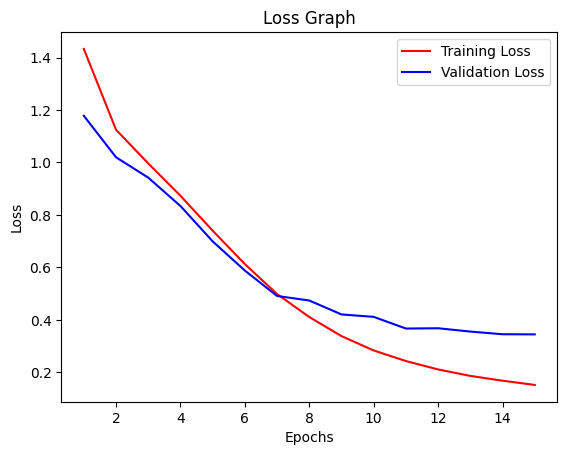

In [ ]:
epochs = [i for i in range(1, 16)]

plt.plot(epochs, trainingHistory.history['loss'], label="Training Loss", color='red')
plt.plot(epochs, trainingHistory.history['val_loss'], label="Validation Loss", color='blue')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Graph")
plt.legend()
plt.show()

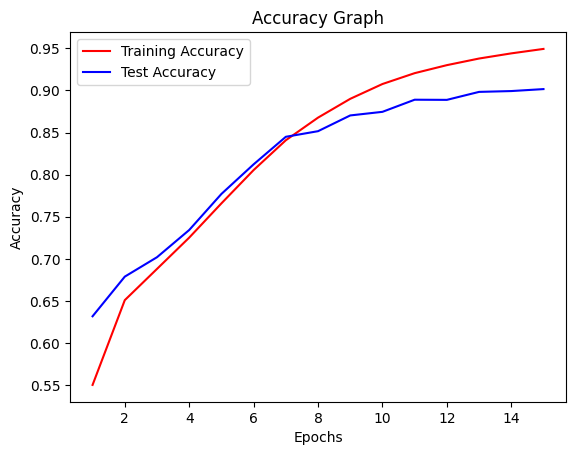

In [ ]:
epochs = [i for i in range(1, 16)]

plt.plot(epochs, trainingHistory.history['accuracy'], label = "Training Accuracy", color = 'red')
plt.plot(epochs, trainingHistory.history['val_accuracy'], label = "Test Accuracy", color = 'blue')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Graph")
plt.legend()
plt.show()

## **Metrics**

In [ ]:
YPred = model.predict(XTest)
print("YPred Shape:", YPred.shape)

2252/2252 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
YPred Shape: (72039, 16)


In [ ]:
predictedCategories = np.argmax(YPred, axis=1)
trueCategories = np.argmax(YTest, axis=1)

In [ ]:
print("Predicted Categories:", predictedCategories)
print("True Categories:", trueCategories)

Predicted Categories: [ 4  6  2 ...  2 13  8]
True Categories: [ 4  6  2 ...  2 13  8]


In [ ]:
cm = confusion_matrix(trueCategories, predictedCategories)
print(classification_report(trueCategories, predictedCategories, target_names=classes))

                     precision    recall  f1-score   support

              Blues       0.93      0.92      0.92      6307
          Classical       0.73      0.84      0.78      3499
            Country       0.92      0.95      0.94     20417
     Easy Listening       0.88      0.82      0.85      6392
         Electronic       0.87      0.85      0.86      4413
       Experimental       0.92      0.76      0.84      1086
               Folk       0.93      0.92      0.93     18326
            Hip-Hop       0.71      0.82      0.76       339
       Instrumental       0.90      0.87      0.88      2926
      International       0.89      0.84      0.87       428
               Jazz       0.79      0.76      0.77       206
Old-Time / Historic       0.78      0.86      0.82       528
                Pop       0.92      0.90      0.91      1772
               Rock       1.00      0.99      0.99      1501
           Soul-RnB       0.87      0.82      0.84      3841
             Spoken    

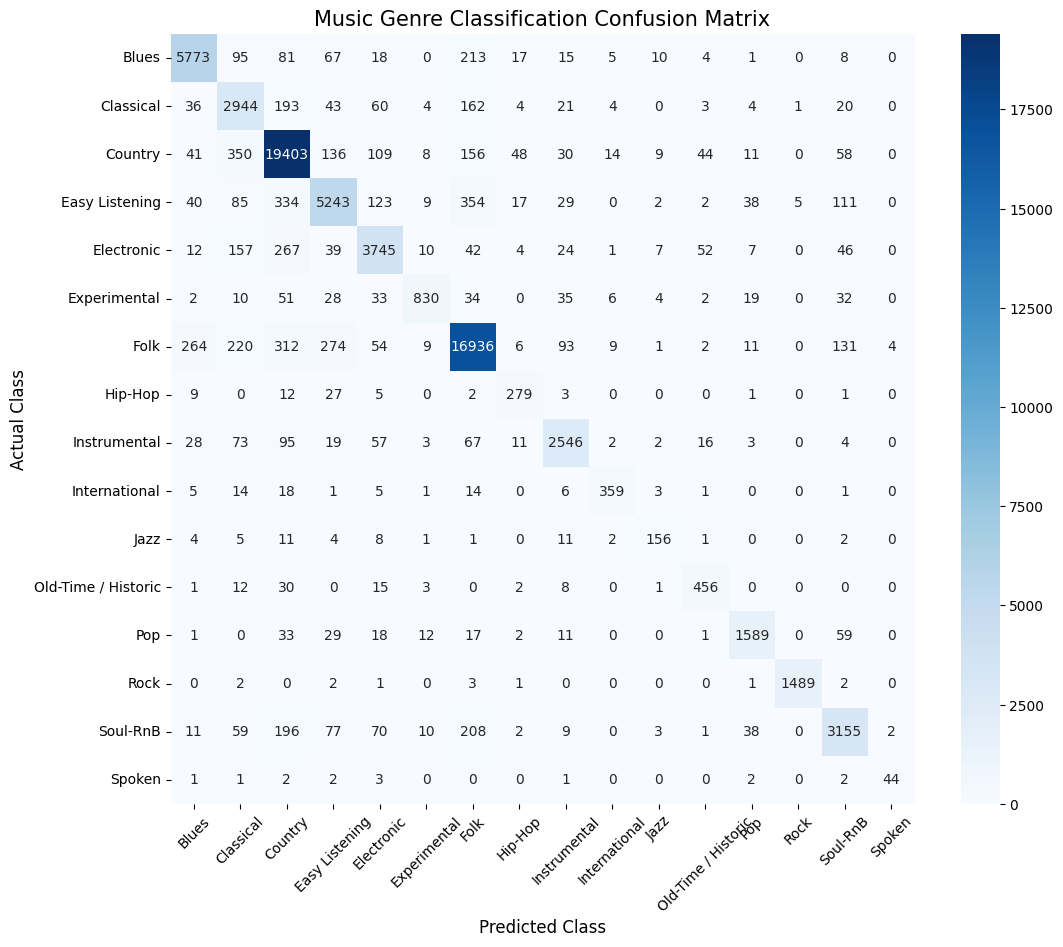

In [ ]:
cm = confusion_matrix(trueCategories, predictedCategories)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)

plt.xlabel("Predicted Class", fontsize=12)
plt.ylabel("Actual Class", fontsize=12)
plt.title("Music Genre Classification Confusion Matrix", fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

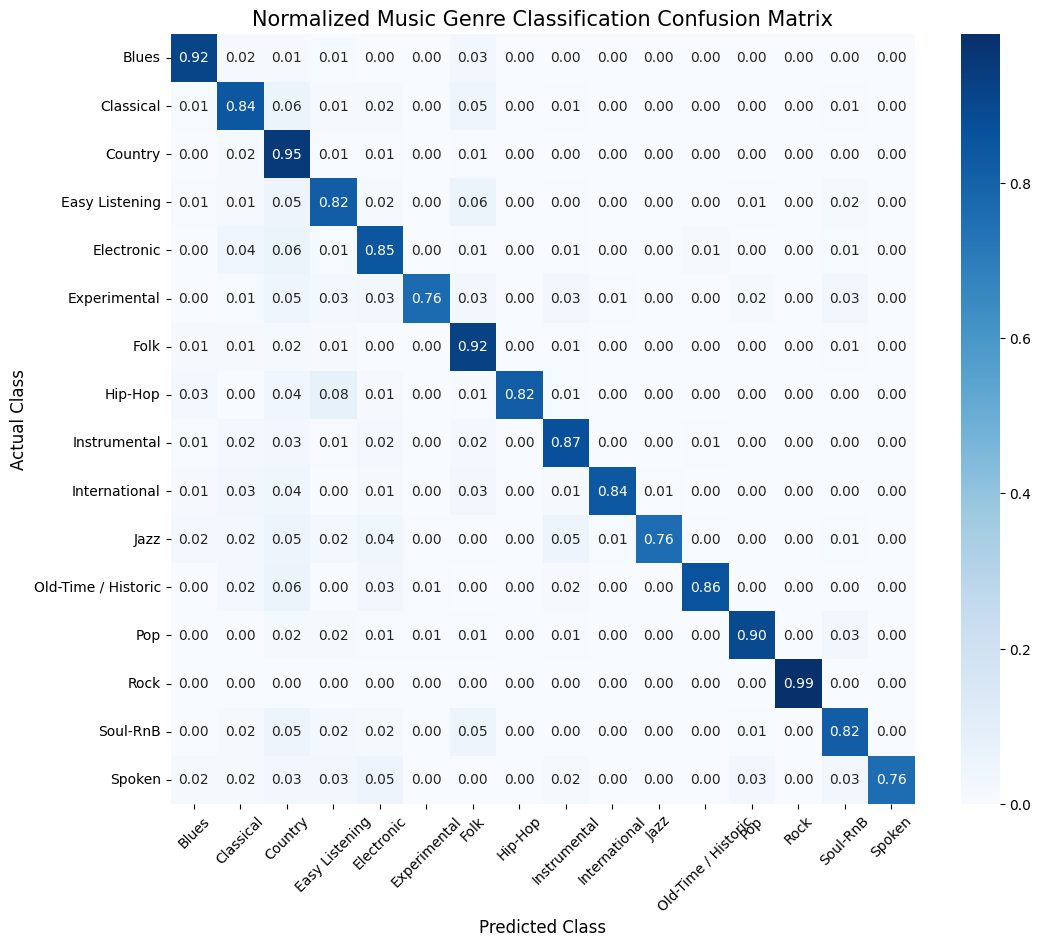

In [ ]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=classes, yticklabels=classes)

plt.xlabel("Predicted Class", fontsize=12)
plt.ylabel("Actual Class", fontsize=12)
plt.title("Normalized Music Genre Classification Confusion Matrix", fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()